In [15]:
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection

import matplotlib.pyplot as plt
import numpy as np

In [16]:
X, y = load_diabetes(return_X_y=True)

In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    predictions = np.array(sum([eta * alg.predict(X) for alg in trees_list]))
    return predictions


def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)


def residual(y, z):
    return - (z - y)


def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

1. Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.

In [5]:
from tqdm import tqdm

eta = 1
max_depths = range(1, 11)


def plot_different_max_depth(n_trees=3, max_depths=max_depths):
    train_errors_depths = []
    test_errors_depths = []
    
    for max_depth in tqdm(max_depths):
        _, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_depths.append(train_errors[-1])
        test_errors_depths.append(test_errors[-1])
        
    print(f'Количество деревьев в бустинге {n_trees}')
    plt.plot(range(len(max_depths)), train_errors_depths, label='train_error')
    plt.plot(range(len(max_depths)), test_errors_depths, label='test_error')
    plt.xlabel('Глубина дерева')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 54.78it/s]


Количество деревьев в бустинге 3


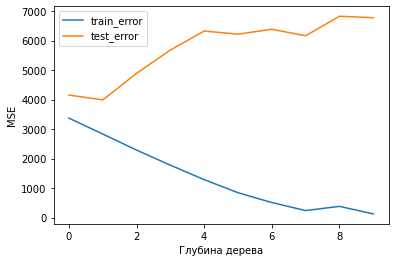

In [6]:
plot_different_max_depth(max_depths=max_depths, n_trees=3)

Вывод: на трёх деревьях видим явное переобучение, так как ошибка на трейне уменьшается, а на тесте увеличивается. Чем глубже деревья - тем модель более переобученная.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.72it/s]

Количество деревьев в бустинге 10


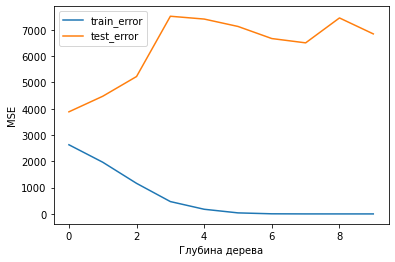

In [7]:
plot_different_max_depth(max_depths=max_depths, n_trees=10)

Вывод: на десяти деревьях видим ещё более явное переобучение.

In [8]:
eta = 1
n_trees = range(1, 50, 1)


def plot_different_num_trees(n_trees=n_trees, max_depth=3):
    train_errors_trees = []
    test_errors_trees = []
    
    for n in tqdm(n_trees):
        _, train_errors, test_errors = gb_fit(n, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_trees.append(train_errors[-1])
        test_errors_trees.append(test_errors[-1])
        
    print(f'Максимальная глубина дерева {max_depth}')
    plt.plot(n_trees, train_errors_trees, label='train_error')
    plt.plot(n_trees, test_errors_trees, label='test_error')
    plt.xlabel('Количество алгоритмов в бустинге')
    plt.ylabel('MSE')
    plt.xticks(n_trees, n_trees)
    plt.legend()
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:58<00:00,  1.19s/it]


Максимальная глубина дерева 2


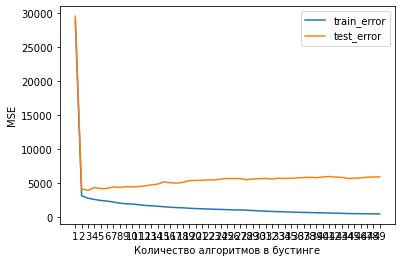

In [9]:
plot_different_num_trees(n_trees=n_trees, max_depth=2)

Вывод: чем больше деревьев, тем больше склонность к переобучению. Хотя переобучение не такое явное, как при изменении максимальной глубины


2. Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [18]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, sample_coef=0.5):
    n_samples = X_train.shape[0]
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        indices = np.random.randint(0, n_samples, int(n_samples * sample_coef))
        X_train_sampled, y_train_sampled = X_train[indices], y_train[indices]
        
        if len(trees) == 0:
            tree.fit(X_train_sampled, y_train_sampled)
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else: 
            target= gb_predict(X_train_sampled, trees, eta)
            tree.fit(X_train_sampled, residual(y_train_sampled, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
       
        trees.append(tree)
    
    return trees, train_errors, test_errors

In [19]:
n_trees = 50
max_depth = 3
eta = 0.3

In [20]:
%%time
_, train_errors_gb, test_errors_gb = gb_fit(n_trees, max_depth,
                                            X_train, X_test, 
                                            y_train, y_test, eta)

Wall time: 313 ms


In [21]:
%%time
_, train_errors_sgb, test_errors_sgb = sgb_fit(n_trees, max_depth,
                                               X_train, X_test, 
                                               y_train, y_test, eta,
                                               sample_coef=0.5)

Wall time: 300 ms


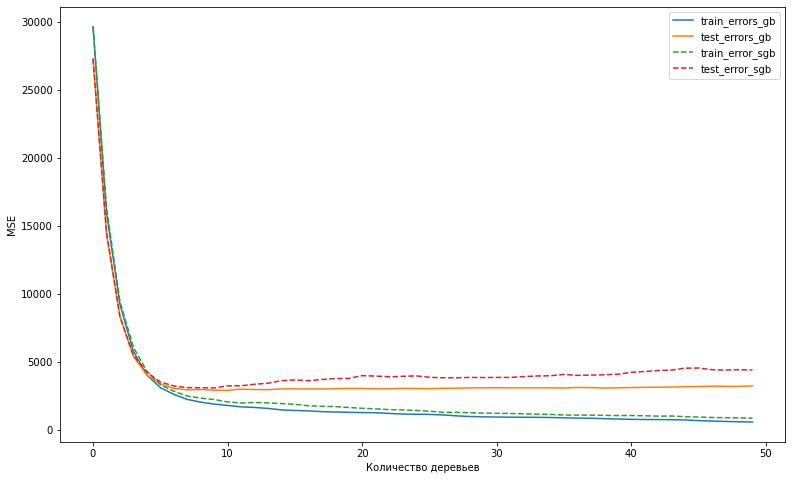

In [22]:
plt.figure(figsize=(13,8))
plt.plot(range(n_trees), train_errors_gb, label='train_errors_gb')
plt.plot(range(n_trees), test_errors_gb, label='test_errors_gb')

plt.plot(range(n_trees), train_errors_sgb, label='train_error_sgb', linestyle='--')
plt.plot(range(n_trees), test_errors_sgb, label='test_error_sgb', linestyle='--')
plt.xlabel('Количество деревьев')
plt.ylabel('MSE')
plt.legend()
plt.show()

Вывод: небольшое отличие, поэтому можно экономить время и делать стахостический градиентный бустинг.
